In [1]:
import keras
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten, Dropout, Add, Activation, Input, BatchNormalization, ZeroPadding2D
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.utils import np_utils
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
#import data
import h5py
import numpy as np

train_set = h5py.File('train_signs.h5', 'r')
train_x = np.array(train_set['train_set_x'][:])
train_y = np.array(train_set['train_set_y'][:])
classes = np.array(train_set['list_classes'].shape[0])

test_set = h5py.File('test_signs.h5', 'r')
test_x = np.array(test_set['test_set_x'][:])
test_y = np.array(test_set['test_set_y'][:])

The label of this picture is 5
There are 6 classes


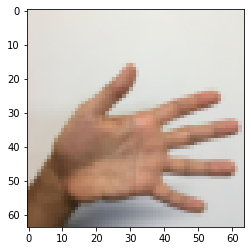

In [3]:
#show our data
plt.imshow(train_x[0])
print('The label of this picture is', train_y[0])
print('There are', classes, 'classes')

In [4]:
#data preprocessing
x_train = train_x / 255
x_test = test_x / 255

y_train = np_utils.to_categorical(train_y)
y_test = np_utils.to_categorical(test_y)

print('trainset has', x_train.shape[0], 'pictures')
print('dataset has', x_test.shape[0], 'pictures')
print('the shape of train data is', x_train.shape)
print('the shape of test data is', x_test.shape)

trainset has 1080 pictures
dataset has 120 pictures
the shape of train data is (1080, 64, 64, 3)
the shape of test data is (120, 64, 64, 3)


In [5]:
def identity_block_cnn(x, f, k):
    
    f1, f2, f3 = f
    
    #convolution path
    x = Conv2D(filters = f1, kernel_size = (1, 1), strides = (1, 1), padding = 'valid')(x)
    x = BatchNormalization(axis = 3)(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters = f2, kernel_size = (k, k), strides = (1, 1), padding = 'same')(x)
    x = BatchNormalization(axis = 3)(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters = f3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid')(x)
    x = BatchNormalization(axis = 3)(x)
    x = Activation('relu')(x)
    
    return x

In [6]:
def convolutional_block_cnn(x, f, k, s):
    
    f1, f2, f3 = f
    
    #convolution path
    x = Conv2D(filters = f1, kernel_size = (1, 1), strides = (s, s), padding = 'valid')(x)
    x = BatchNormalization(axis = 3)(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters = f2, kernel_size = (k, k), strides = (1, 1), padding = 'same')(x)
    x = BatchNormalization(axis = 3)(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters = f3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid')(x)
    x = BatchNormalization(axis = 3)(x)
    x = Activation('relu')(x)
    
    return x

In [7]:
x_input = Input(shape = (64, 64, 3))

x = ZeroPadding2D((3, 3))(x_input)

x = Conv2D(64, (7, 7), strides = (2, 2))(x)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)
x = MaxPooling2D((3, 3), strides = (2, 2))(x)

x = convolutional_block_cnn(x, [64, 64, 256], 3, 1)
x = identity_block_cnn(x, [64, 64, 256], 3)
x = identity_block_cnn(x, [64, 64, 256], 3)

x = convolutional_block_cnn(x, [128, 128, 512], 3, 2)
x = identity_block_cnn(x, [128, 128, 512], 3)
x = identity_block_cnn(x, [128, 128, 512], 3)
x = identity_block_cnn(x, [128, 128, 512], 3)

x = convolutional_block_cnn(x, [256, 256, 1024], 3, 2)
x = identity_block_cnn(x, [256, 256, 1024], 3)
x = identity_block_cnn(x, [256, 256, 1024], 3)
x = identity_block_cnn(x, [256, 256, 1024], 3)
x = identity_block_cnn(x, [256, 256, 1024], 3)
x = identity_block_cnn(x, [256, 256, 1024], 3)

x = convolutional_block_cnn(x, [512, 512, 2048], 3, 2)
x = identity_block_cnn(x, [512, 512, 2048], 3)
x = identity_block_cnn(x, [512, 512, 2048], 3)

x = AveragePooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(classes, activation = 'softmax')(x)

model = Model(inputs = x_input, outputs = x)

model.summary()














_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 70, 70, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        9472      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        4160    

In [8]:
import time
from keras.callbacks import ModelCheckpoint
from keras import optimizers

adam = optimizers.Adam(lr=0.0002)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("plain50.h5", monitor='val_acc', verbose=1, mode='max', save_best_only=True)

start = time.time()
history = model.fit(x_train, y_train, validation_split=0.15, epochs=100, batch_size=32, callbacks=[checkpoint])
end = time.time()

print("Total time: ", end - start)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 918 samples, validate on 162 samples
Epoch 1/100
918/918 [==============================] - 76s 82ms/step - loss: 1.9291 - acc: 0.1983 - val_loss: 8.8125 - val_acc: 0.1358

Epoch 00001: val_acc improved from -inf to 0.13580, saving model to plain50.h5
Epoch 2/100
918/918 [==============================] - 40s 44ms/step - loss: 1.8212 - acc: 0.2037 - val_loss: 5.4792 - val_acc: 0.1728

Epoch 00002: val_acc improved from 0.13580 to 0.17284, saving model to plain50.h5
Epoch 3/100
918/918 [==============================] - 40s 43ms/step - loss: 1.8188 - acc: 0.2298 - val_loss: 6.8312 - val_acc: 0.1481

Epoch 00003: val_acc did not improve from 0.17284
Epoch 4/100
918/918 [==============================] - 39s 43ms/step - loss: 1.7818 - acc: 0.2505 - val_loss: 6.7244 - val_acc: 0.1543

Epoch 00004: val_acc did not improve from 0.17284
Epoch 5/100
918/918 [==============================

918/918 [==============================] - 19s 21ms/step - loss: 0.6437 - acc: 0.7723 - val_loss: 1.2278 - val_acc: 0.6543

Epoch 00037: val_acc improved from 0.63580 to 0.65432, saving model to plain50.h5
Epoch 38/100
918/918 [==============================] - 20s 22ms/step - loss: 0.5270 - acc: 0.8072 - val_loss: 1.1086 - val_acc: 0.6728

Epoch 00038: val_acc improved from 0.65432 to 0.67284, saving model to plain50.h5
Epoch 39/100
918/918 [==============================] - 20s 22ms/step - loss: 0.4666 - acc: 0.8420 - val_loss: 2.5380 - val_acc: 0.5062

Epoch 00039: val_acc did not improve from 0.67284
Epoch 40/100
918/918 [==============================] - 20s 22ms/step - loss: 0.4743 - acc: 0.8301 - val_loss: 3.0838 - val_acc: 0.3889

Epoch 00040: val_acc did not improve from 0.67284
Epoch 41/100
918/918 [==============================] - 20s 22ms/step - loss: 0.3931 - acc: 0.8704 - val_loss: 2.6776 - val_acc: 0.4198

Epoch 00041: val_acc did not improve from 0.67284
Epoch 42/100
9


Epoch 00079: val_acc did not improve from 0.84568
Epoch 80/100
918/918 [==============================] - 19s 21ms/step - loss: 0.0652 - acc: 0.9847 - val_loss: 2.2546 - val_acc: 0.5494

Epoch 00080: val_acc did not improve from 0.84568
Epoch 81/100
918/918 [==============================] - 19s 21ms/step - loss: 0.1873 - acc: 0.9564 - val_loss: 1.1904 - val_acc: 0.7160

Epoch 00081: val_acc did not improve from 0.84568
Epoch 82/100
918/918 [==============================] - 21s 23ms/step - loss: 0.1677 - acc: 0.9564 - val_loss: 3.2749 - val_acc: 0.4691

Epoch 00082: val_acc did not improve from 0.84568
Epoch 83/100
918/918 [==============================] - 20s 22ms/step - loss: 0.1485 - acc: 0.9619 - val_loss: 2.1394 - val_acc: 0.5988

Epoch 00083: val_acc did not improve from 0.84568
Epoch 84/100
918/918 [==============================] - 20s 22ms/step - loss: 0.1211 - acc: 0.9684 - val_loss: 1.4688 - val_acc: 0.6790

Epoch 00084: val_acc did not improve from 0.84568
Epoch 85/100
9

In [9]:
model = keras.models.load_model("plain50.h5")
pred = model.evaluate(x_test, y_test)
print('loss is', pred[0])
print('accuracy is', pred[1])

120/120 [==============================] - 6s 54ms/step
loss is 0.9175009806950887
accuracy is 0.799999996026357


In [10]:
np.save('p50_100_loss.npy', history.history['loss'])
np.save('p50_100_acc.npy', history.history['acc'])
np.save('p50_100_vloss.npy', history.history['val_loss'])
np.save('p50_100_vacc.npy', history.history['val_acc'])